<a href="https://colab.research.google.com/github/afrojaakter/RNN/blob/main/GRU_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Gated Recurrent Unit (GRU), which is trained to make a binary decision, namely whether the integral of the white noise input is in total positive or negative, outputing either a +1 or a -1 to encode the decision.

# Train GRU

In [ ]:
from __future__ import print_function, division, absolute_import
from functools import partial
from scipy.spatial.distance import pdist, squareform
import datetime
import h5py
import jax.numpy as np
from jax import jacrev, random, vmap, jit, grad, lax
from jax.experimental import optimizers
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from importlib import reload
import numpy as onp             # original CPU-backed 
import os
import sys
import time

#####Utils: Utility functions related reading / writing files and random keys JAX library.

In [ ]:
def ensure_dir(file_path):
  """Make sure the directory exists, create if it does not."""
  directory = os.path.dirname(file_path)
  if not os.path.exists(directory):
    os.makedirs(directory)

def write_file(data_fname, data_dict):
  """Write a simple dictionary using h5py."""
  try:
    ensure_dir(data_fname)
    with h5py.File(data_fname, 'w') as hf:
      for k in data_dict:
        hf.create_dataset(k, data=data_dict[k])
        # add attributes
  except IOError:
    print("Cannot write % for writing." % data_fname)
    raise

def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:
    2-tuple (new key for further generators, key generator)
  """
  keys = random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])

#####RNN: GRU functions for init, definition and running.

In [ ]:
MAX_SEED_INT = 10000000

def gru_params(key, **rnn_hps):
  """Generate GRU parameters
  Arguments:
    key: random.PRNGKey for random bits
    n: hidden state size
    u: input size
    i_factor: scaling factor for input weights
    h_factor: scaling factor for hidden -> hidden weights
    h_scale: scale on h0 initial condition
  Returns:
    a dictionary of parameters
  """
  key, skeys = keygen(key, 6)
  u = rnn_hps['u']              # input
  n = rnn_hps['n']              # hidden
  o = rnn_hps['o']              # output
  
  ifactor = rnn_hps['i_factor'] / np.sqrt(u)
  hfactor = rnn_hps['h_factor'] / np.sqrt(n)
  hscale = rnn_hps['h_scale']
  
  wRUH = random.normal(next(skeys), (n+n,n)) * hfactor
  wRUX = random.normal(next(skeys), (n+n,u)) * ifactor
  wRUHX = np.concatenate([wRUH, wRUX], axis=1)
  
  wCH = random.normal(next(skeys), (n,n)) * hfactor
  wCX = random.normal(next(skeys), (n,u)) * ifactor
  wCHX = np.concatenate([wCH, wCX], axis=1)

  # Include the readout params in the GRU, though technically
  # not a part of the GRU.
  pfactor = 1.0 / np.sqrt(n)
  wO = random.normal(next(skeys), (o,n)) * pfactor
  bO = np.zeros((o,))
  return {'h0' : random.normal(next(skeys), (n,)) * hscale,
          'wRUHX' : wRUHX,
          'wCHX' : wCHX,
          'bRU' : np.zeros((n+n,)),
          'bC' : np.zeros((n,)),
          'wO' : wO,
          'bO' : bO}


def sigmoid(x):
  """ Implement   1 / ( 1 + exp( -x ) )   in terms of tanh."""
  return 0.5 * (np.tanh(x / 2.) + 1)


def gru(params, h, x, bfg=0.5):
  """Implement the GRU equations.
  Arguments:
    params: dictionary of GRU parameters
    h: np array of  hidden state
    x: np array of input
    bfg: bias on forget gate (useful for learning if > 0.0)
  Returns:
    np array of hidden state after GRU update"""

  hx = np.concatenate([h, x], axis=0)
  ru = np.dot(params['wRUHX'], hx) + params['bRU']
  r, u = np.split(ru, 2, axis=0)
  r = sigmoid(r)
  u = u + bfg
  u = sigmoid(u)
  rhx = np.concatenate([r * h, x])
  c = np.tanh(np.dot(params['wCHX'], rhx) + params['bC'])
  return u * h + (1.0 - u) * c


def gru_scan(params, h, x, bfg=0.5):
  """Return the output twice for scan."""
  h = gru(params, h, x, bfg)
  return h, h


def affine(params, x):
  """Implement y = w x + b
  Args: 
    params: dictionary of affine parameters
    x: np array of input"""
  return np.dot(params['wO'], x) + params['bO']

# Affine expects n_W_m m_x_1, but passing in t_x_m (has txm dims) So
# map over first dimension to hand t_x_m.  I.e. if affine yields n_y_1
# = dot(n_W_m, m_x_1), then batch_affine yields t_y_n.
batch_affine = vmap(affine, in_axes=(None, 0))


def gru_run_with_h0(params, x_t, h0):
  """Run the Vanilla RNN T steps, where T is shape[0] of input.
  Args:
    params: dict of GRU parameters
    x_t: np array of inputs with dim ntime x u
    h0: initial condition for hidden state
  Returns: 
    2-tuple of np arrays (hidden states w dim ntime x n, outputs w dim ntim x o)
  """

  f = partial(gru_scan, params)
  _, h_t = lax.scan(f, h0, x_t)
  o_t = batch_affine(params, h_t)
  return h_t, o_t  


def gru_run(params, x_t):
  """Run the Vanilla RNN T steps, where T is shape[0] of input.
  
  Args:
    params: dict of GRU parameters
    x_t: np array of inputs with dim ntime x u
  Returns: 
    2-tuple of np arrays (hidden states w dim ntime x n, outputs w dim ntim x o)
  """  
  return gru_run_with_h0(params, x_t, params['h0'])

  
# Let's make it handle batches using `vmap`
batched_rnn_run = vmap(gru_run, in_axes=(None, 0))
batched_rnn_run_w_h0 = vmap(gru_run_with_h0, in_axes=(None, 0, 0))
  
  
def loss(params, inputs_bxtxu, targets_bxtxo, targets_mask_t, l2reg):
  """Compute the least squares loss of the output, plus L2 regularization.
  Args: 
    params: dict RNN parameters
    inputs_bxtxu: np array of inputs batch x time x input dim
    targets_bxtxo: np array of targets batx x time x output dim
    targets_mask_t: list of time indices where target is active
    l2reg: float, hyper parameter controlling strength of L2 regularization
  
  Returns:
    dict of losses
  """
  _, outs_bxtxo = batched_rnn_run(params, inputs_bxtxu)
  l2_loss = l2reg * optimizers.l2_norm(params)**2
  outs_bxsxo = outs_bxtxo[:, targets_mask_t, :]
  targets_bxsxo = targets_bxtxo[:, targets_mask_t, :]
  lms_loss = np.mean((outs_bxsxo - targets_bxsxo)**2)
  total_loss = lms_loss + l2_loss
  return {'total' : total_loss, 'lms' : lms_loss, 'l2' : l2_loss}


def update_w_gc(i, opt_state, opt_update, get_params,
                x_bxt, f_bxt, f_mask_bxt, max_grad_norm, l2reg):
  """Update the parameters w/ gradient clipped, gradient descent updates.
  Arguments: 
    i: batch number
    opt_state: parameters plus optimizer state
    opt_update: optimizer state update function
    get_params: function to extract parameters from optimizer state
    x_bxt: rnn inputs
    f_bxt: rnn targets
    f_mask_bxt: masks for when target is defined
    max_grad_norm: maximum norm value gradient is allowed to take
    l2reg: l2 regularization hyperparameter
  
  Returns: 
    opt_state tuple (as above) that includes updated parameters and optimzier 
      state.
  """
  params = get_params(opt_state)

  def training_loss(params, x_bxt, f_bxt, l2reg):
    return loss(params, x_bxt, f_bxt, f_mask_bxt, l2reg)['total']
  
  grads = grad(training_loss)(params, x_bxt, f_bxt, l2reg)
  clipped_grads = optimizers.clip_grads(grads, max_grad_norm)
  return opt_update(i, clipped_grads, opt_state)


loss_jit = jit(loss)
update_w_gc_jit = jit(update_w_gc, static_argnums=(2,3))


def run_trials(batched_run_fun, io_fun, nbatches, batch_size):
  """Run a bunch of trials and save everything in a dictionary.
  
  Args: 
    batched_run_fun: function for running rnn in batch with signature either
      inputs -> hiddens, outputs OR
      inputs, h0s -> hiddens, outputs
    io_fun: function for creating inputs, targets, masks 
      and initial conditions. initial conditions may be None and the parameter 
      is used.  
    nbatches: Number of batches to run
    batch_size: Size of batch to run
  Returns: 
    A dictionary with the trial structure, keys are: 
      inputs, hiddens, outputs and targets, each an np array with dim
      nbatches*batch_size * ntimesteps * dim 
  """
  inputs = []
  hiddens = []
  outputs = []
  targets = []
  h0s = []
  for n in range(nbatches):
    data_seeds = onp.random.randint(0, MAX_SEED_INT, size=batch_size)
    keys = np.array([random.PRNGKey(ds) for ds in data_seeds])
    input_b, target_b, masks_b, h0s_b = io_fun(keys)
    if h0s_b is None:
      h_b, o_b = batched_run_fun(input_b)
    else:
      h_b, o_b = batched_run_fun(input_b, h0s_b)      
      h0s.append(h0s_b)
      
    inputs.append(input_b)
    hiddens.append(h_b)
    outputs.append(o_b)
    targets.append(target_b)

    
  trial_dict = {'inputs' : onp.vstack(inputs), 'hiddens' : onp.vstack(hiddens),
                'outputs' : onp.vstack(outputs), 'targets' : onp.vstack(targets)}
  if h0s_b is not None:
    trial_dict['h0s'] = onp.vstack(h0s)
  else:
    trial_dict['h0s'] = None
  return trial_dict


def plot_params(params):
  """Plot the parameters of the GRU.
  Args: 
    params: Parmeters of the GRU
  """
  plt.figure(figsize=(18,8))
  plt.subplot(231)
  plt.stem(params['wO'][0,:])
  plt.title('wO - output weights')
  
  plt.subplot(232)
  plt.stem(params['h0'])
  plt.title('h0 - initial hidden state')
  
  plt.subplot(233)
  plt.imshow(params['wRUHX'], interpolation=None)
  plt.title('wRUHX - recurrent weights')
  plt.colorbar()
  
  plt.subplot(234)
  plt.imshow(params['wCHX'], interpolation=None)
  plt.title('wCHX')
  
  plt.subplot(235)
  plt.stem(params['bRU'])
  plt.title('bRU - recurrent biases')
  
  plt.subplot(236)
  xdim = 1
  rnn_fun_h = lambda h : gru(params, h, np.zeros(xdim))
  dFdh = jacrev(rnn_fun_h)(params['h0'])
  evals, _ = onp.linalg.eig(dFdh)
  x = onp.linspace(-1, 1, 1000)
  plt.plot(x, onp.sqrt(1-x**2), 'k')
  plt.plot(x, -onp.sqrt(1-x**2), 'k')
  plt.plot(onp.real(evals), onp.imag(evals), '.')
  plt.axis('equal')
  plt.xlabel('Real($\lambda$)')
  plt.ylabel('Imaginary($\lambda$)')
  plt.title('Eigenvalues of $dF/dh(h_0)$')

  
def plot_examples(ntimesteps, rnn_internals, nexamples=1):
  """Plot some input/hidden/output triplets.
  
  Args: 
    ntimesteps: Number of time steps to plot
    rnn_internals: dict returned by run_trials.
  """
  plt.figure(figsize=(nexamples*5, 16))
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, bidx+1)
    plt.plot(rnn_internals['inputs'][bidx,:], 'k')
    plt.xlim([0, ntimesteps])
    plt.title('Example %d' % (bidx))
    if bidx == 0:
      plt.ylabel('Input')
      
  ntoplot = 10
  closeness = 0.25
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, nexamples+bidx+1)
    plt.plot(rnn_internals['hiddens'][bidx, :, 0:ntoplot] +
             closeness * onp.arange(ntoplot), 'b')
    plt.xlim([0, ntimesteps])
    if bidx == 0:
      plt.ylabel('Hidden Units')
      
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, 2*nexamples+bidx+1)
    plt.plot(rnn_internals['outputs'][bidx,:,:], 'r', label = 'Outputs')
    plt.plot(rnn_internals['targets'][bidx,:,:], 'k', label = 'targets')    
    plt.xlim([0, ntimesteps])
    plt.xlabel('Timesteps')
    if bidx == 0:
      plt.ylabel('Output')
    plt.legend()

##### Decision: Routines for creating white noise and integrated white noise.

In [ ]:
def build_input_and_target_binary_decision(input_params, key):
  """Build white noise input and decision targets.
  The decision is whether the white noise input has a perfect integral
  greater than, or less than, 0. Output a +1 or -1, respectively.
  Arguments: 
    inputs_params: tuple of parameters for this decision task
    key: jax random key for making randomness
  Returns:
    3-tuple of inputs, targets, and the target mask, indicating 
      which time points have optimization pressure on them"""
  
  bias_val, stddev_val, T, ntime = input_params
  dt = T/ntime

  # Create the white noise input.
  key, skeys = keygen(key, 2)
  random_sample = random.normal(next(skeys), (1,))[0]
  bias = bias_val * 2.0 * (random_sample - 0.5)
  stddev = stddev_val / np.sqrt(dt)
  random_samples = random.normal(next(skeys), (ntime,))
  noise_t = stddev * random_samples
  white_noise_t = bias + noise_t

  # * dt, intentionally left off to get output scaling in O(1).
  pure_integration_t = np.cumsum(white_noise_t)
  decision = 2.0*((pure_integration_t[-1] > 0.0)-0.5)
  targets_t = np.zeros(pure_integration_t.shape[0]-1)
  targets_t = np.concatenate([targets_t,
                              np.array([decision], dtype=float)], axis=0)
  inputs_tx1 = np.expand_dims(white_noise_t, axis=1)
  targets_tx1 = np.expand_dims(targets_t, axis=1)
  target_mask = np.array([ntime-1]) # When target is defined.
  print('targetMstk', target_mask)
  return inputs_tx1, targets_tx1, target_mask


# Now batch it and jit.
build_input_and_target = build_input_and_target_binary_decision
build_inputs_and_targets = vmap(build_input_and_target, in_axes=(None, 0))
build_inputs_and_targets_jit = jit(build_inputs_and_targets,
                                   static_argnums=(0,))


def plot_batch(input_params, input_bxtxu, target_bxtxo=None, output_bxtxo=None,
               errors_bxtxo=None, ntoplot=1):
  """Plot some white noise / integrated white noise examples."""
  bval, sval, T, ntimesteps = input_params
  plt.figure(figsize=(16,12))
  plt.subplot(311)
  xs = np.arange(1, ntimesteps+1)
  plt.plot(xs, input_bxtxu[0:ntoplot,:,0].T)
  plt.xlim([1, ntimesteps])
  plt.ylabel('Noise')
  plt.subplot(312)
  if output_bxtxo is not None:
    plt.plot(xs, output_bxtxo[0:ntoplot,:,0].T);
    plt.xlim([1, ntimesteps]);
  if target_bxtxo is not None:
    plt.stem([ntimesteps]*ntoplot, target_bxtxo[0:ntoplot,ntimesteps-1,0].T, '--');
    plt.xlim([1, ntimesteps]);
    plt.ylabel("Decision")
  if errors_bxtxo is not None:
    plt.subplot(313)
    plt.plot(xs, errors_bxtxo[0:ntoplot,:,0].T, '--');
    plt.xlim([1, ntimesteps]);
    plt.ylabel("|Errors|")
  plt.xlabel('Timesteps')

### Decision task and parameters for GRU

In [ ]:
T = 1.0         # Arbitraty amount time, roughtly physiological
ntimesteps = 25 # Divide T into this many bin
bval = 0.01     # bias value limit
sval = 0.025    # standart deviation (before dividing by sqrt(dt))
input_params = (bval, sval, T, ntimesteps)

# GRU and task hyperparameters
u = 1   # Number of inputs to the GRU
n = 100 # Number of units in the GRU
o = 1   # Number of outputs i the GRU

#Optimization hyper parameters
num_batchs = 20000 # Total number of batches to train on
batch_size = 128 # Number of examples in each batch
eval_batch_size = 1024 # The size of a batch for evaluating the RNN
step_size = 0.04 # Initial learning rate
decay_factor = 0.9999 #Learning rate decay rate
#gradient clipping is Hugely important for training all RNN variables
max_grad_norm = 10.0 # max gradient norm before clipping, clip to this value
l2reg = 0.00002 # amount of L2 regularization on the weights
adam_b1 = 0.9 # Adam parameters
adam_b2 = 0.999
adam_eps = 1e-1
print_every = 100 #print training information in every 100 itereations

###Plotting two example input/target pairs

Plot some examples for the decision making task. The loss is only defined at the final time step.

Seed: 476125
targetMstk [24]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


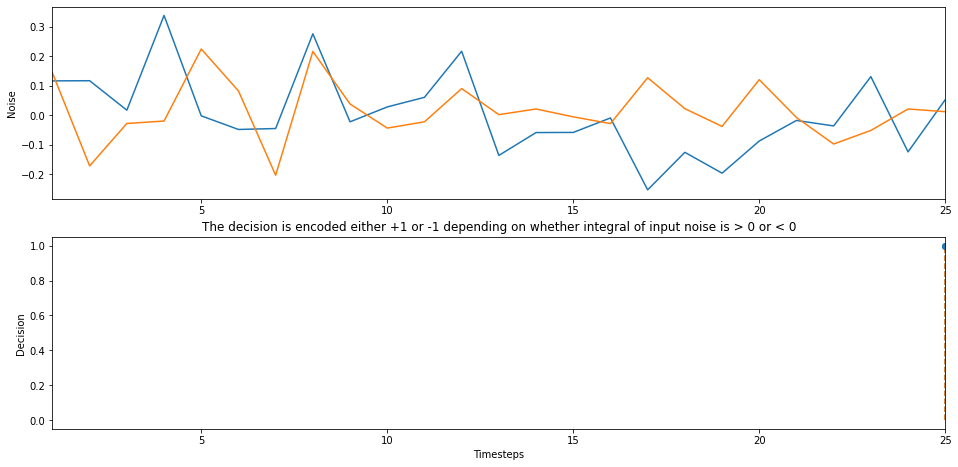

In [ ]:
##seed = onp.random.randint(0, 1000000) # get randomness from CPU level numpy
seed = 476125
print("Seed: %d" % seed)
key = random.PRNGKey(seed) # create a random key for jax for use on device.
# Plot a few input/target examples to make sure things look sane.
ntoplot = 2    # number of examples to plot
key, skey = random.split(key, 2)
skeys = random.split(skey, ntoplot) # get ntoplot random keys
# decision.build_inputs_and_targets_jit: build white noise input and decision targets.
##The decision is whether the white noise input has a perfect integral
##greater than, or less than, 0. Output a +1 or -1, respectively.
inputs, targets, _ = build_inputs_and_targets_jit(input_params,
                                                           skeys)

# Plot the input to the RNN and the target for the RNN.
plot_batch(input_params, inputs, targets, ntoplot=ntoplot)
plt.title('The decision is encoded either +1 or -1 depending \
on whether integral of input noise is > 0 or < 0');

The first graph is showing the two examples of white noises that will be using as a input to the GRU. The second graph shows the decision, whether the input white noise has a perfect integral
greater than 0, or less than 0. If the integral of the input noise is greated than 0 then the output +1 or otherwise the output is -1. 

The loss is only defined at the final time step.

###Init some parameters for training.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:231: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:235: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:248: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warni

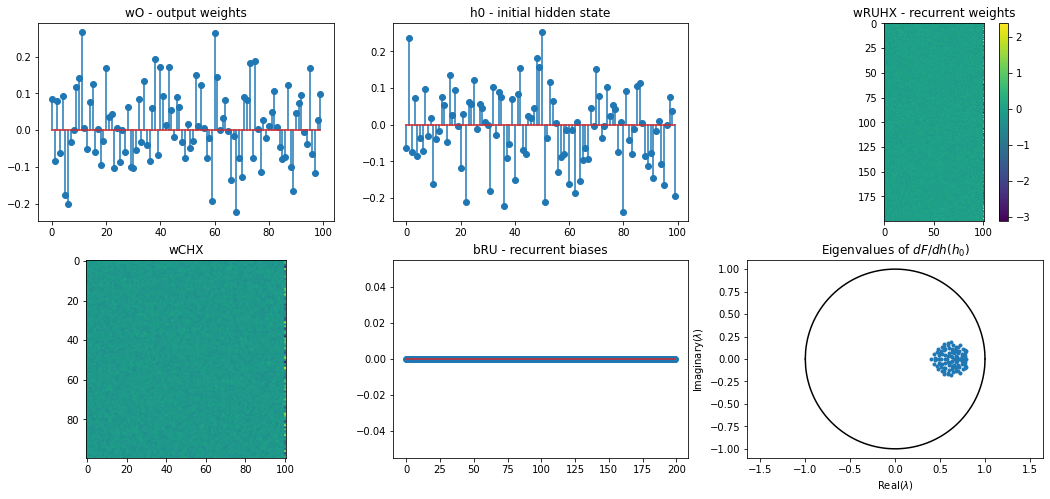

In [ ]:
# load rnn.py
#GRU functions for init, definition and running.
key, subkey = random.split(key, 2)
## gru_params: Generate GRU parameters
init_params = gru_params(subkey, u=u, n=n, o=o,
                             i_factor=1.0, h_factor=1.0, h_scale=0.1)
#plot the GRU parameters
plot_params(init_params)

The above figures shows the initial parameters used to train GRU. 
- w0: output weights
- h0: initial hidden state
- wRUHX: recurrent weights
- wCH: hidden state weights
- wCX: input state weights
- wCHX: wCH + wCX
- bRU: recurrent bias 
- Eigenvalues of $dF/dh(h_o)$: eigenvalues at initial hidden state

###Train the GRU

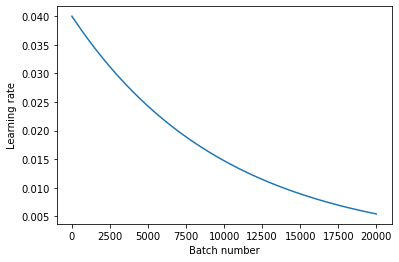

In [ ]:
# Create a decay function for the learning rate
decay_fun = optimizers.exponential_decay(step_size, decay_steps=1, 
                                         decay_rate=decay_factor)
batch_idxs = onp.linspace(1, num_batchs)
plt.plot(batch_idxs, [decay_fun(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

Above figure shows the decay of step size during the traning.

In [ ]:
'''Training starts'''

# Initialize the optimizer. 
opt_init, opt_update, get_params = optimizers.adam(decay_fun, adam_b1, adam_b2, adam_eps)
opt_state = opt_init(init_params)

# Run the optimization loop, first jit'd call will take a minute.
start_time = time.time()
all_train_losses = []
for batch in range(num_batchs):
    key, subkey = random.split(key, 2)
    skeys = random.split(subkey, batch_size)
    inputs, targets, target_masks = build_inputs_and_targets_jit(input_params, skeys)
    opt_state = update_w_gc_jit(batch, opt_state, opt_update, get_params, inputs,
                                    targets, target_masks, max_grad_norm, l2reg)
    if batch % print_every == 0:
        params = get_params(opt_state)
        all_train_losses.append(loss_jit(params, inputs, targets, target_masks, l2reg))
        train_loss = all_train_losses[-1]['total']
        batch_time = time.time() - start_time
        step_size = decay_fun(batch) #learning rate or lenght of step in each iteration
        s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
        print(s.format(batch, batch_time, step_size, train_loss))
        start_time = time.time()
        
# List of dicts to dict of lists
all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

targetMstk [24]
Batch 0 in 2.92 sec, step size: 0.04000, training loss 0.8621
Batch 100 in 0.53 sec, step size: 0.03960, training loss 0.1588
Batch 200 in 0.54 sec, step size: 0.03921, training loss 0.1447
Batch 300 in 0.53 sec, step size: 0.03882, training loss 0.1570
Batch 400 in 0.52 sec, step size: 0.03843, training loss 0.0983
Batch 500 in 0.53 sec, step size: 0.03805, training loss 0.1014
Batch 600 in 0.52 sec, step size: 0.03767, training loss 0.0853
Batch 700 in 0.53 sec, step size: 0.03730, training loss 0.0988
Batch 800 in 0.53 sec, step size: 0.03692, training loss 0.0989
Batch 900 in 0.55 sec, step size: 0.03656, training loss 0.0772
Batch 1000 in 0.55 sec, step size: 0.03619, training loss 0.0911
Batch 1100 in 0.54 sec, step size: 0.03583, training loss 0.1398
Batch 1200 in 0.51 sec, step size: 0.03548, training loss 0.0742
Batch 1300 in 0.53 sec, step size: 0.03512, training loss 0.0701
Batch 1400 in 0.53 sec, step size: 0.03477, training loss 0.0687
Batch 1500 in 0.52 se

### Visualization of loss through training
- Since the data is synthetic and randomly generated on each batch, there is no difference between training loss and evaluation loss



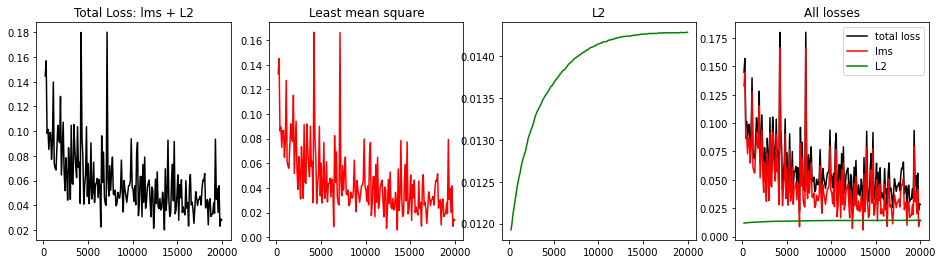

In [ ]:
xs = onp.linspace(0, num_batchs, int((num_batchs / print_every)))
x1 = 2
x2 = int(num_batchs / print_every)
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.plot(xs[x1:x2], all_train_losses['total'][x1:x2], 'k')
plt.title('Total Loss: lms + L2')

plt.subplot(142)
plt.plot(xs[x1:x2], all_train_losses['lms'][x1:x2], 'r')
plt.title('Least mean square')

plt.subplot(143)
plt.plot(xs[x1:x2], all_train_losses['l2'][x1:x2], 'g');
plt.title('L2')

plt.subplot(144)
plt.plot(xs[x1:x2], all_train_losses['total'][x1:x2], 'k', label = 'total loss')
plt.plot(xs[x1:x2], all_train_losses['lms'][x1:x2], 'r', label = 'lms')
plt.plot(xs[x1:x2], all_train_losses['l2'][x1:x2], 'g', label = 'L2')
plt.title('All losses')
plt.legend()

The first grahp is the sum of least mean square loss and L2 loss. The second and third graph shows the least mean square and L2 loss respectively. The last graph shows all losses in one graph. 

###Testing

In [ ]:
# Take a batch for an evalulation loss, notice the L2 penalty is 0
# for the evaluation and the batch is bigger.
params = get_params(opt_state)
key, subkey = random.split(key, 2)
skeys = random.split(subkey, batch_size)
inputs, targets, masks = build_inputs_and_targets_jit(input_params, skeys)
eval_loss = loss_jit(params, inputs, targets, masks, l2reg=0.0)['total']
eval_loss_str = "{:.5f}".format(eval_loss)
print("Loss on a new large batch: %s" % (eval_loss_str))

Loss on a new large batch: 0.04077


###Visualizations of trained system

targetMstk [24]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


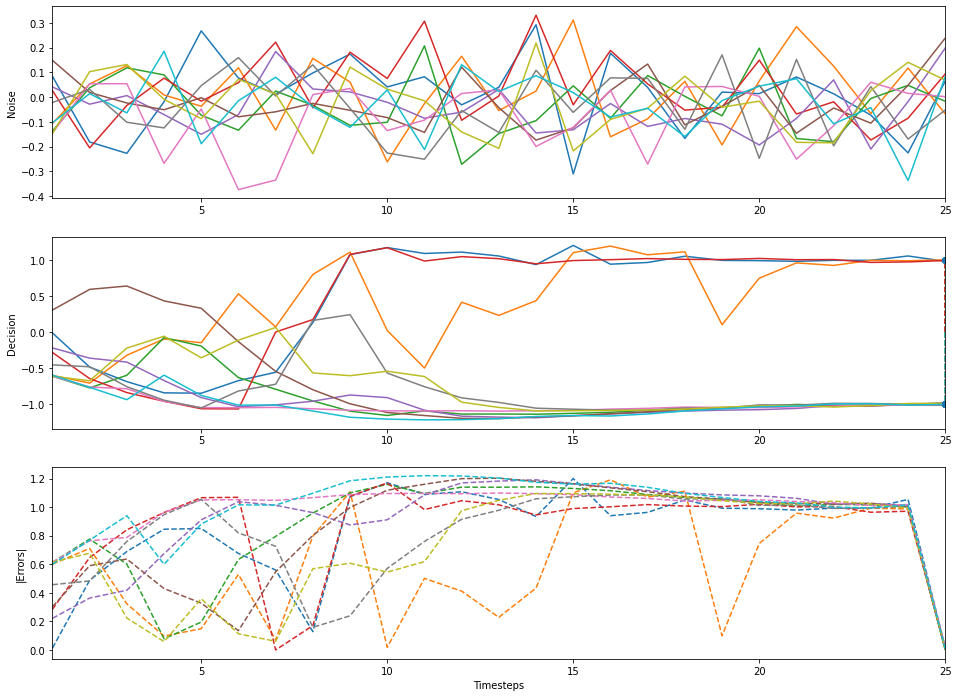

In [ ]:
# Visualize how good this trained integrator is
def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = \
        build_inputs_and_targets_jit(input_params, keys)
    h0s_b = None # Use trained h0
    masks_b = None # Not used
    return inputs_b, targets_b, masks_b, h0s_b

# rnn.batched_rnn_run = vmap(gru_run, in_axes=(None, 0)) handles batches using vmap
# jax.vmap, which is a transformation which automatically “vectorizes” a function.
rnn_run = lambda inputs: batched_rnn_run(params, inputs)
give_trained_h0 = lambda batch_size : np.array([params['h0']] * batch_size)

nexamples = 400
# rnn.trials: Run a bunch of trials and save everything in a dictionary:
# inputs, hiddens, outputs and targets, each an np array with dim
# nbatches*batch_size * ntimesteps * dim
rnn_internals = run_trials(rnn_run, inputs_targets_no_h0s, 1, nexamples)

#Plot some white noise / integrated white noise examples
plot_batch(input_params, rnn_internals['inputs'], 
                    rnn_internals['targets'], rnn_internals['outputs'], 
                    onp.abs(rnn_internals['targets'] - rnn_internals['outputs']), 
                    ntoplot=10)

- The first plot shows the 10 input examples of whilte noise. 
- The second plot shows the integration of the input noise predicted by GRU per timesteps for the input noise. At the 25th timestep the result is either +1 or -1 if the integration is greater than 0 or less than 0 respectively.
- the last plot shows the absolute error between the terget output and GRU predicted output. We notice the error at the final timestep (25s) is almost 0. Which means GRU classfiy the input noises exactly for these examples. 

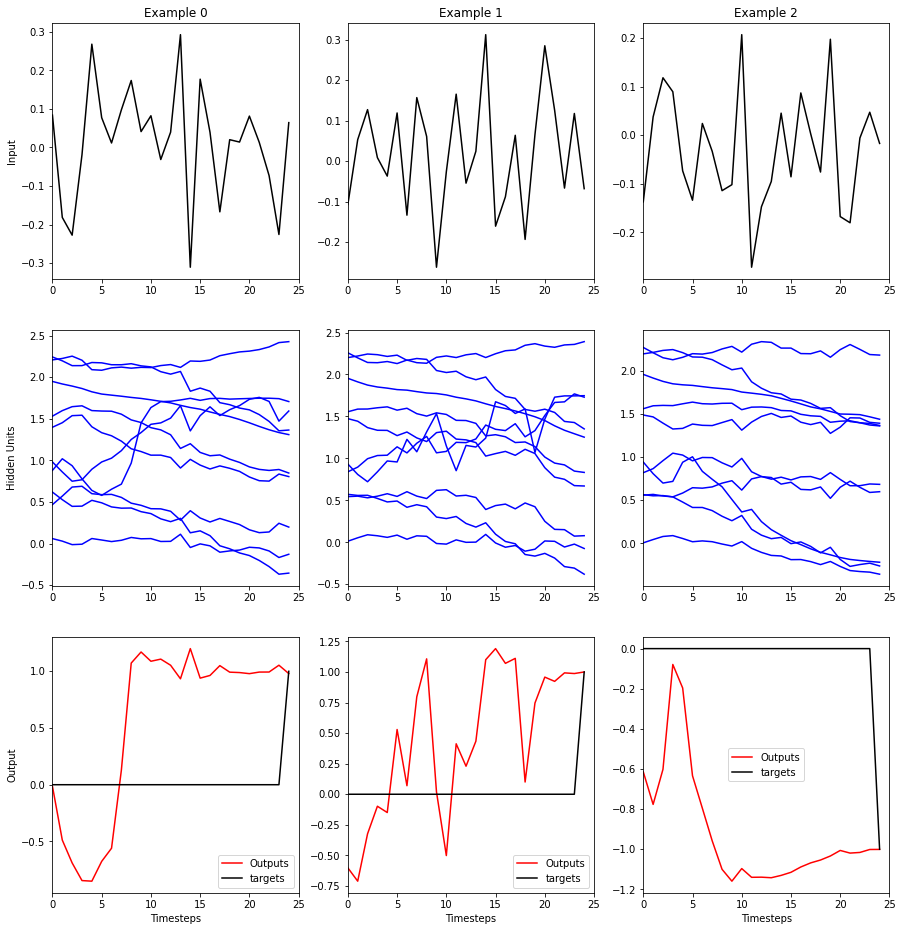

In [ ]:
# Visualize the input/hidden/output state, as an example.
#ntimesteps: Number of time steps to plot
#rnn_internals: dict returned by run_trials
plot_examples(ntimesteps, rnn_internals, 3)


The above figure shows 3 examples with their input unit, hidden unit and predicted output with the tergets.
As we see from the graphs in the last row the GRU prediction at the final timestep is either 1 or -1.

###Visualization of trained parameters

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:231: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:235: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:248: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warni

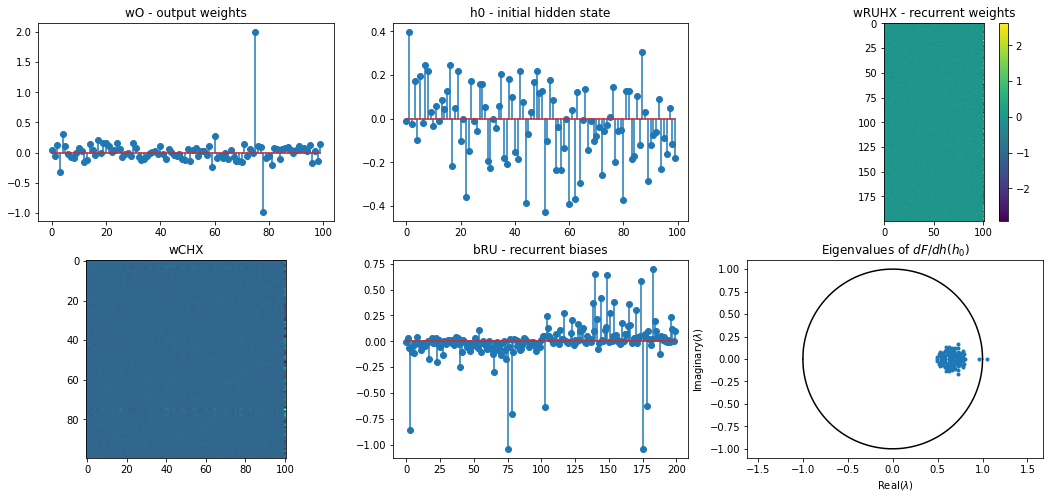

In [ ]:
plot_params(params)

The above figure shows the output weights, initial hidden state, recurrent weights, recurrent biases and the eigenvalues after the GRU training is finished. 

Eigenvalues are plotted in the complex plane. There is one eigenvalue very close to $(1,0)$ in the complex plane, this means the system can integrate. The rest of the eigenvalues are within the unit circle, meaning they are stable, decaying modes.

###Saving
Saving the network parameters to reproduce the resluts.

In [ ]:
# Define directories, etc.
task_type = 'decision'
rnn_type = 'gru'
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
data_dir = os.path.join(os.path.join('/tmp', rnn_type), task_type)

print(data_dir)
print(fname_uniquifier)

/tmp/gru/decision
2021-02-15_07:00:28


In [ ]:
# Save parameters
params_fname = ('trained_params_' + rnn_type + '_' + task_type + '_' + \
                eval_loss_str + '_' + fname_uniquifier + '.h5')
params_fname = os.path.join(data_dir, params_fname)

print("Saving params in %s" % (params_fname))
write_file(params_fname, params)

Saving params in /tmp/gru/decision/trained_params_gru_decision_0.04077_2021-02-15_07:00:28.h5
